In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.optimize import least_squares
import math

# 1. Defining Functions

## Single First Order Reaction

In [2]:
T_ref = 273 + 5
gas_const = scipy.constants.gas_constant
# [[A]_0, k(T_ref), E_a]
single_params = np.array([97.9, (7.4 * 10**(-5)) ,115.83]) # purity of nr ce-sds

def single_rate_constant(T, kT_ref, E_a):
    e = math.e**(((-E_a)/gas_const)*((1/T) - (1/T_ref)))
    return (kT_ref * e)

def A_single (params, t,T):
    k = single_rate_constant(T, params[1], params[2])
    e = math.e**((-1)* k *t)
    return (params[0] * e)

def B_single(params, t, T, B_0):
    A = A_single(params, t, T)
    return (B_0 + params[0] - A)

## Parallel First Order Reaction

In [3]:
# [[A]0, [B]0, kB(Tref), kC(Tref), Ea,B, Ea,C]
parallel_params = [99.1, 0.9, 6.13 * (10 ** (-5)), 1.25 * (10 ** (-4)), 111.45, 103.32]

def parallel_rate_constant(T, kT_refX, E_aX):
    e = math.e**(((-E_aX)/gas_const)*((1/T) - (1/T_ref)))
    return (kT_refX * e)

def A_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*( k_b + k_c )*t)
    return (params[0] * e)

"""
For B and C, we are taking the assumption given in the article that: 

[B] = [A]_0\frac{k_b}{k_b + k_c} ...

where k_b and k_c would be txhe rate czonstant of the reference temperature
"""
def B_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*(k_b + k_c) * t)
    total_k = params[2] + params[3]
    x = params[0] * (params[2] / total_k) * (1 - e)
    return (x - params[1])
    
def C_parallel(params, t, T):
    k_b = parallel_rate_constant(T, params[2], params[4])
    k_c = parallel_rate_constant(T, params[3], params[5])
    e = math.e**((-1)*(k_b + k_c) * t)
    total_k = params[2] + params[3]
    x = params[0] * (params[3] / total_k) * (1 - e)
    # [C]_0 = 100 - ([A]_0 + [B]_0
    return (x - (100 - (params[0] + params[1])))

## Single N-th Order Reaction

In [4]:
# [[A]_0, k(T_ref), E_a, N]
single_n_params = np.array([99.6, (5.63 * 10**(-4)) ,120, 0])

def A_n_single(params, t, T):
    k = single_rate_constant(T, params[1], params[2])
    A = (params[0] ** (1 - params[3])) - k * t * (1-params[3])
    return (A ** (1/(1-params[3])))
            
def B_n_single(params, t, T):
    A = A_n_single(params, t, T)
    return (100 - A)

# 2. Test with Data (AI-Generated Data)

In [5]:
df = pd.read_csv('sample.csv')
df['[B]'] = df['[B] HMW'] + df['[C] LMW']

df['Temp (K)'] = df['Temp (K)'].map({
    278.15: 278, 
    298.15: 298, 
    313.15: 313})

t0_df = df[df['Time (months)'] == 0]
t1_df = df[(df['Time (months)'] == 1) & (df['Temp (K)'].isin([278, 298, 313]))]
t3_df = df[(df['Time (months)'] == 3) & (df['Temp (K)'].isin([278, 298, 313]))]
t6_df = df[(df['Time (months)'] == 6) & (df['Temp (K)'].isin([278, 298]))]

df_train = pd.concat([t0_df, t1_df, t3_df, t6_df], ignore_index=True)
df_train

,Time (months),Temp (°C),Temp (K),[A] Monomer (single),[A] Monomer (parallel),[B] HMW,[C] LMW,[B]
0,0,5,278,99.100000,99.100000,0.000000,0.000000,0.000000
1,0,25,298,99.100000,99.100000,0.000000,0.000000,0.000000
2,0,40,313,99.100000,99.100000,0.000000,0.000000,0.000000
3,1,5,278,99.099142,99.099142,0.000240,0.000619,0.000858
4,1,25,298,99.081539,99.081539,0.006074,0.012386,0.018461
5,1,40,313,98.956546,98.956546,0.052304,0.091150,0.143454
6,3,5,278,99.097425,99.097425,0.000719,0.001856,0.002575
7,3,25,298,99.044628,99.044628,0.018219,0.037152,0.055372
8,3,40,313,98.670261,98.670261,0.156685,0.273054,0.429739
9,6,5,278,99.094851,99.094851,0.001438,0.003711,0.005149


In [6]:
df[df['Time (months)'] == 0]

,Time (months),Temp (°C),Temp (K),[A] Monomer (single),[A] Monomer (parallel),[B] HMW,[C] LMW,[B]
0,0,5,278,99.1,99.1,0.0,0.0,0.0
37,0,25,298,99.1,99.1,0.0,0.0,0.0
74,0,40,313,99.1,99.1,0.0,0.0,0.0


### real data

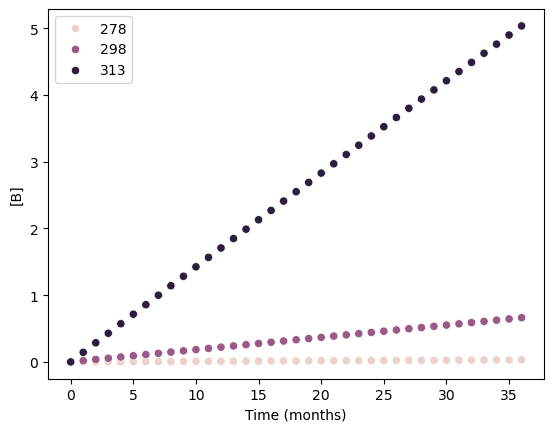

In [7]:
sns.scatterplot(x = df['Time (months)'], y = df['[B]'], hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

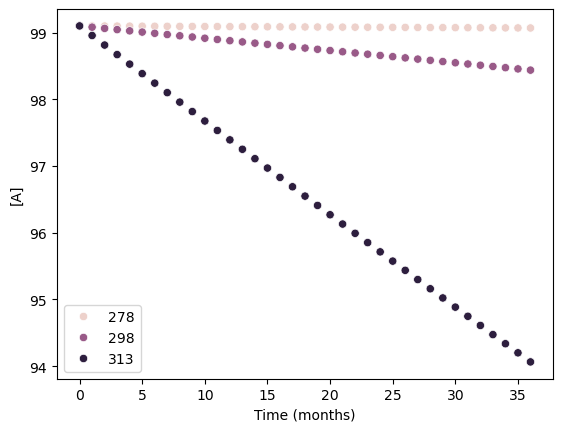

In [8]:
sns.scatterplot(x = df['Time (months)'], y = df['[A] Monomer (single)'], hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

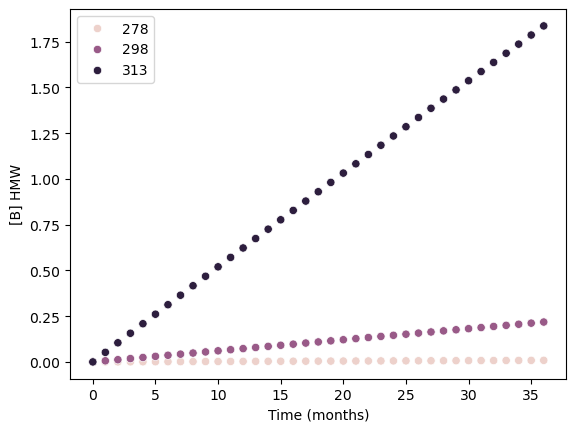

In [9]:
sns.scatterplot(x = df['Time (months)'], y = df['[B] HMW'], hue = df['Temp (K)'])
plt.ylabel("[B] HMW")
plt.legend()
plt.show()

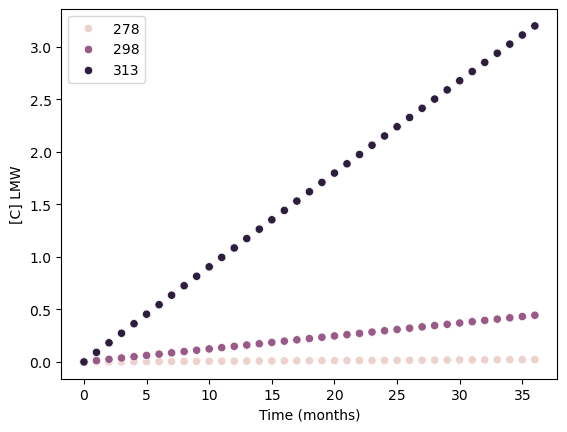

In [10]:
sns.scatterplot(x = df['Time (months)'], y = df['[C] LMW'], hue = df['Temp (K)'])
plt.ylabel("[C] LMW")
plt.legend()
plt.show()

During data generation, LMW and HMW might got switched as the last two figures showed that the HMW is lower than LMW, therefore switching needs to be done.

In [11]:
df.rename(columns={'[B] HMW': '[C] LMW'}, inplace=True)
df.rename(columns={'[C] LMW': '[B] HMW'}, inplace=True)

## Single First-Order Reaction

In [12]:
initial_guess_single = np.array([100, (0.0005) , 120])

In [13]:
lower_bounds_single_first = [80, 0, 0]
upper_bounds_single_first = [100, np.inf, np.inf]


def residuals_B_single(params, combined_input_data, y_observed, B_0_fixed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_single(params, t, T, B_0_fixed) for t, T in zip(t_vals, T_vals)])
    return np.sum((y_observed - y_predicted) ** 2)

def batch_B_single(params, combined_input_data, B_0_fixed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_single(params, t, T, B_0_fixed) for t, T in zip(t_vals, T_vals)])
    return y_predicted

def batch_A_single(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([A_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

In [14]:
result_B = least_squares(
    residuals_B_single,
    initial_guess_single,
    args=(df_train, df_train['[B]'], 0 ), # taking assumption that [B]_0 is 0
    bounds=(lower_bounds_single_first, upper_bounds_single_first),
    verbose = 2,
    method='trf'
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.9620e-02                                    6.75e-02    
       1              2         1.4265e-02      1.54e-02       1.22e+02       3.35e-03    
       2             11         1.4114e-02      1.50e-04       6.42e-05       6.78e+00    
       3             15         1.4046e-02      6.80e-05       1.46e-05       2.57e+00    
       4             16         1.4040e-02      6.84e-06       1.46e-05       4.15e-04    
       5             17         1.4040e-02      9.40e-08       5.85e-08       4.11e-04    
`xtol` termination condition is satisfied.
Function evaluations 17, initial cost 2.9620e-02, final cost 1.4040e-02, first-order optimality 4.11e-04.


In [15]:
new_params = result_B.x
new_params

array([9.15565159e+01, 2.54639797e-04, 2.42050956e+02])

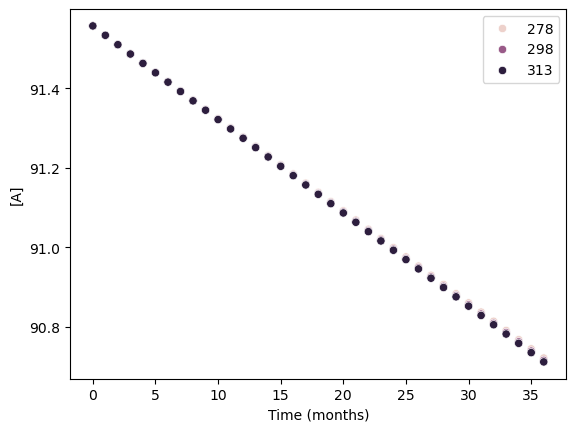

In [16]:
preds = batch_A_single(new_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

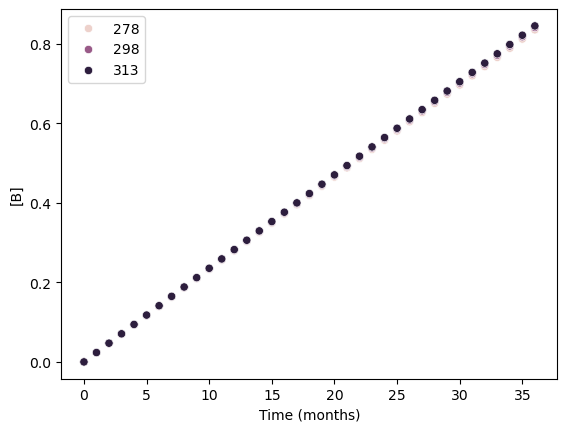

In [17]:
preds = batch_B_single(new_params, df, 0)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

### using the supporting material's parameters

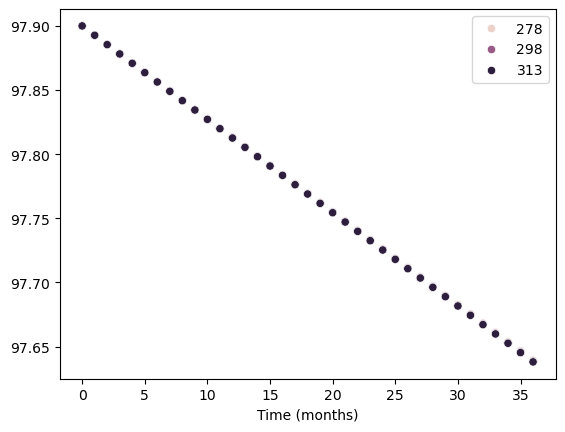

In [18]:
preds = batch_A_single(single_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])

plt.legend()
plt.show()

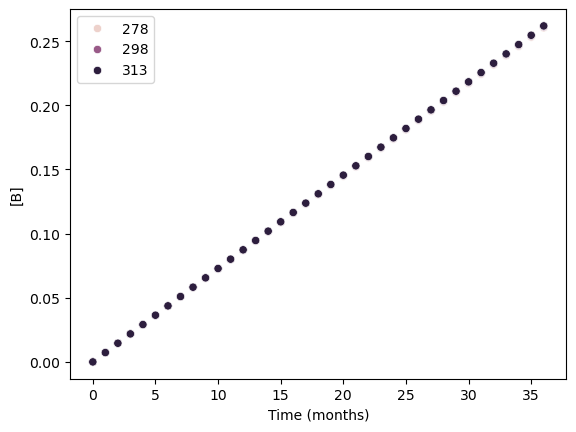

In [19]:
preds = batch_B_single(single_params, df, 0)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

Looking at the parameters used on the purity acquired from NR CE-SDS, it seems that the data generated by GPT is somewhat usable as when we test the parameters, we acquire similar results.

## Single N-th Order Reaction

In [20]:
lower_bounds_single_n = [80, 0, 0, 0]
upper_bounds_single_n = [100, np.inf, np.inf, np.inf]

def residuals_B_n_single(params, combined_input_data, y_observed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_n_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return np.sum((y_observed - y_predicted) ** 2)
    
def batch_B_n_single(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_n_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

def batch_A_n_single(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([A_single(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

In [21]:
initial_guess_n_single = np.array([100, (0.0005) , 120, 0])

In [22]:
result_B_n = least_squares(
    residuals_B_n_single,
    initial_guess_n_single,
    args=(df_train, df_train['[B]'] ), # taking assumption that [B]_0 is 0
    bounds=(lower_bounds_single_n, upper_bounds_single_n),
    verbose = 2,
    method='trf'
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3903e-02                                    6.60e+00    
       1              2         2.0667e-02      3.24e-03       1.00e-01       2.81e-02    
       2              3         1.9881e-02      7.87e-04       1.65e-03       2.59e-02    
       3              4         1.8486e-02      1.39e-03       3.33e-03       2.20e-02    
       4              5         1.6311e-02      2.17e-03       6.75e-03       1.55e-02    
       5              6         1.3823e-02      2.49e-03       1.37e-02       6.57e-03    
       6              7         1.3391e-02      4.32e-04       2.73e-02       8.08e-01    
       7              9         1.3338e-02      5.35e-05       1.96e-02       4.52e-03    
       8             10         1.3304e-02      3.33e-05       3.83e-04       4.36e-03    
       9             11         1.3242e-02      6.25e-05       7.68e-04       4.04e-03    

In [23]:
new_params_n = result_B_n.x
new_params_n

array([9.99589631e+01, 1.31066131e-02, 1.20000012e+02, 4.19685829e-04])

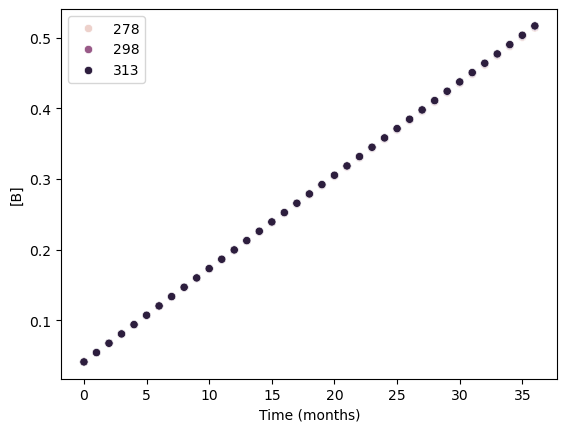

In [24]:
preds = batch_B_n_single(new_params_n, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

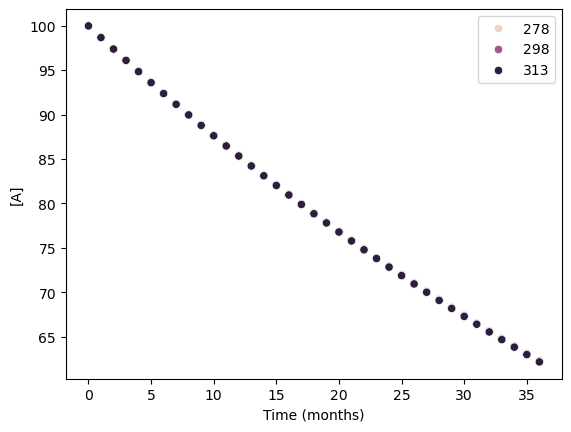

In [25]:
preds = batch_A_n_single(new_params_n, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

### using supported material's parameter (Monomer)

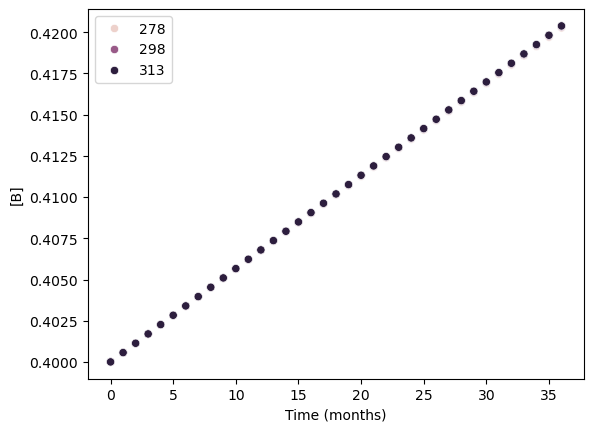

In [26]:
preds = batch_B_n_single(single_n_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

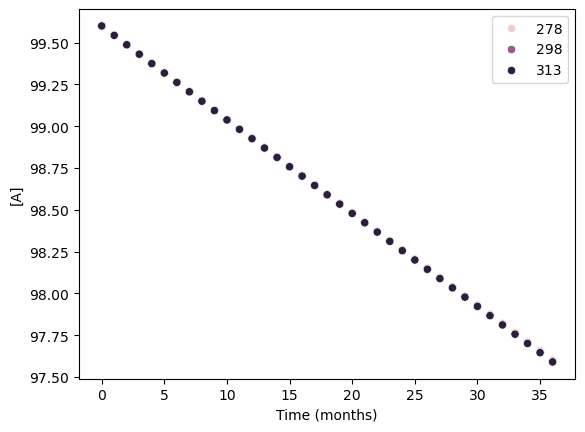

In [27]:
preds = batch_A_n_single(single_n_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

There seems to be a really big decay on [A] as it drops from 100 to 65 in 35 months, eventhough [B] only grows from 0 to 0.5, which is quite close to the prediction using the supporting material's parameters

## Parallel First Order Reaction

In [28]:
lower_bounds_parallel = [0, 0, 0, 0, -np.inf, -np.inf]
upper_bounds_parallel = [100, 100, np.inf, np.inf, np.inf, np.inf]
    
def residual_total_parallel(params, combined_input_data, y_observed):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    A_predicted = np.array([A_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])
    B_predicted = np.array([B_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])
    C_predicted = np.array([C_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])

    all_predictions = np.concatenate((A_predicted, B_predicted, C_predicted))

    return np.sum((all_predictions - y_observed) ** 2)

def batch_A_parallel(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([A_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

def batch_B_parallel(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([B_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

def batch_C_parallel(params, combined_input_data):
    t_vals = np.array(combined_input_data['Time (months)'])
    T_vals = np.array(combined_input_data['Temp (K)'])
    y_predicted = np.array([C_parallel(params, t, T) for t, T in zip(t_vals, T_vals)])
    return y_predicted

In [29]:
initial_params = [95, 1, 0.0001, 0.0001, 400, 500]

In [30]:
target_parallel = np.concatenate((df_train['[A] Monomer (single)'].values, 
                                  df_train['[B] HMW'].values, 
                                  df_train['[C] LMW'].values))

In [47]:
result_parallel = least_squares(
    residual_total_parallel,
    initial_params,
    args=(df_train, target_parallel),
    bounds=(lower_bounds_parallel, upper_bounds_parallel),
    verbose=2,
    method='trf'
)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.9139e+04                                    2.45e+06    
       1              8         4.3917e+04      2.52e+04       1.36e+00       2.01e+05    
       2              9         3.1677e+04      1.22e+04       3.80e-01       1.37e+05    
       3             10         1.6143e+04      1.55e+04       6.62e-01       6.42e+04    
       4             11         3.7511e+03      1.24e+04       1.18e+00       1.38e+05    
       5             16         3.7294e+03      2.16e+01       2.12e-04       6.63e+04    
       6             17         3.7227e+03      6.72e+00       2.14e-04       1.33e+04    
       7             18         3.7209e+03      1.86e+00       3.39e-04       1.33e+04    
       8             19         3.7171e+03      3.72e+00       6.77e-04       1.33e+04    
       9             20         3.7097e+03      7.44e+00       1.36e-03       1.33e+04    

The Dogbox method of optimisation is unsuitable.

In [48]:
new_params_parallel = result_parallel.x
new_params_parallel

array([9.87621365e+01, 1.09867381e+00, 1.05855313e-03, 1.36074862e-38,
       4.00000000e+02, 5.00000000e+02])

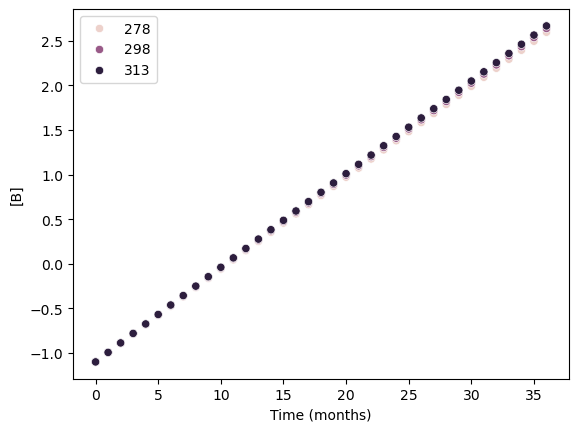

In [49]:
preds = batch_B_parallel(new_params_parallel, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

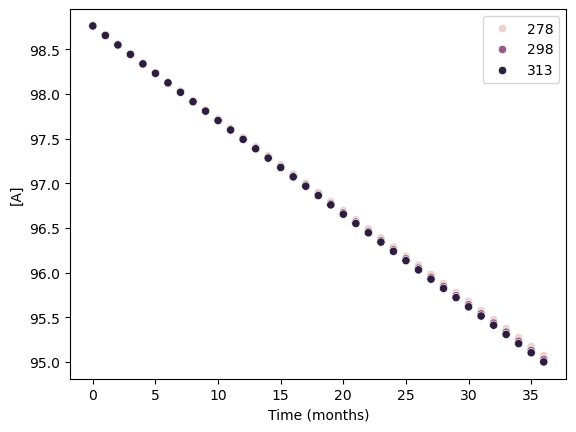

In [50]:
preds = batch_A_parallel(new_params_parallel, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

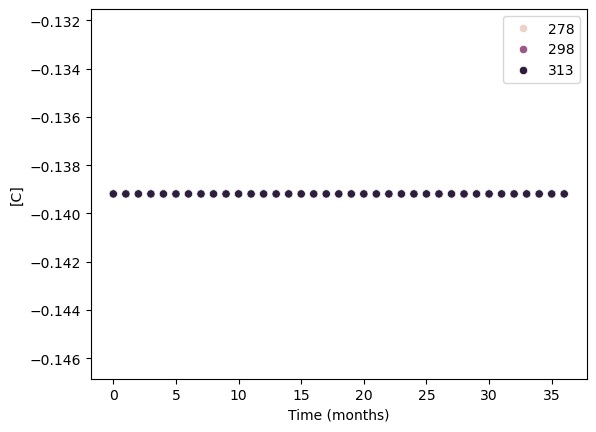

In [51]:
preds = batch_C_parallel(new_params_parallel, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[C]")
plt.legend()
plt.show()

Seems like the fitting mechanism wasn't really fond of [C] as it just produces useless parameters.

Additionally, as I have been experimenting with only eleven total data points for training, where the data comes from one (AI-generated) drug product, it begs the question: were the predictors in the article fitted with other types of drugs too? If so, how can it be done? Keep in mind that every molecule would have a different rate constant and activation energies.

### Test with Supporting Material's Parameters

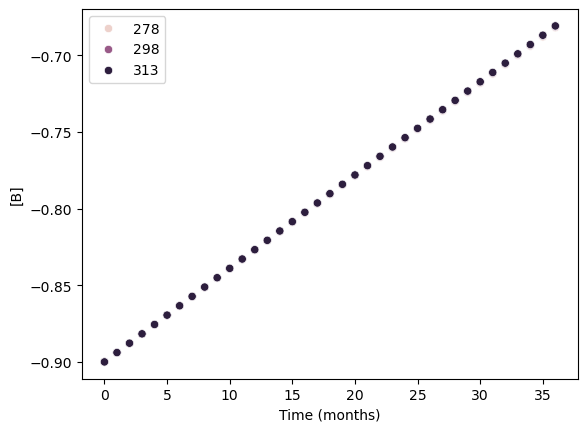

In [36]:
preds = batch_B_parallel(parallel_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[B]")
plt.legend()
plt.show()

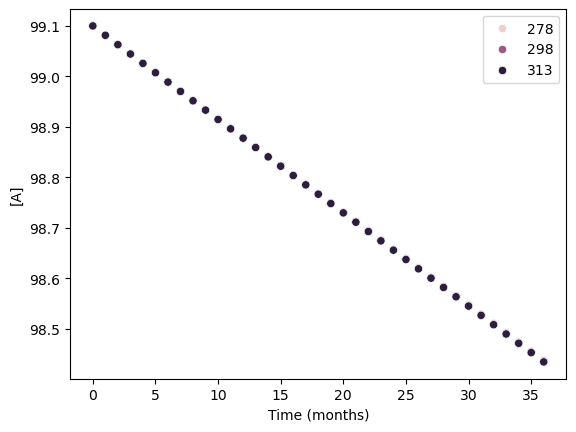

In [37]:
preds = batch_A_parallel(parallel_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[A]")
plt.legend()
plt.show()

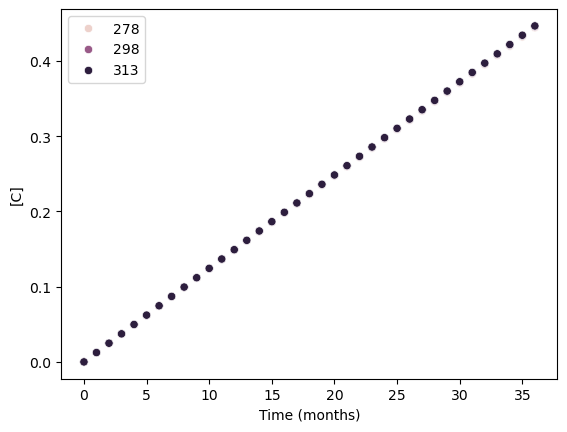

In [38]:
preds = batch_C_parallel(parallel_params, df)
sns.scatterplot(x = df['Time (months)'], y = preds, hue = df['Temp (K)'])
plt.ylabel("[C]")
plt.legend()
plt.show()

The assumption to use dogbox was unclear on the article.

In [39]:
import pickle as pk

## Exporting Parameters

In [40]:
results = (result_B, result_B_n, result_parallel)
with open('results.pk', 'wb') as fp:
    pk.dump(results, fp)

In [41]:
results

(     message: `xtol` termination condition is satisfied.
      success: True
       status: 3
          fun: [ 1.676e-01]
            x: [ 9.156e+01  2.546e-04  2.421e+02]
         cost: 0.014039507901694373
          jac: [[ 2.695e-05  9.623e+00 -2.416e-06]]
         grad: [ 4.516e-06  1.613e+00 -4.048e-07]
   optimality: 0.0004106246749842487
  active_mask: [0 0 0]
         nfev: 17
         njev: 6,
      message: `xtol` termination condition is satisfied.
      success: True
       status: 3
          fun: [ 1.589e-01]
            x: [ 9.996e+01  1.311e-02  1.200e+02  4.197e-04]
         cost: 0.0126281043247941
          jac: [[-2.019e-03  3.853e-04 -1.328e-06  1.908e-05]]
         grad: [-3.209e-04  6.123e-05 -2.110e-07  3.031e-06]
   optimality: 1.3168100503164739e-05
  active_mask: [0 0 0 0]
         nfev: 167
         njev: 124,
      message: The maximum number of function evaluations is exceeded.
      success: False
       status: 0
          fun: [ 1.305e+01]
            